<b>Author</b>: Vladislav Zamkovoy <br>
<b>Date created</b>: 15.02.2021 <br>

<b>Date last modified</b>: 15.02.2021 <br>
<b>Last modified by</b>: Vladislav Zamkovoy <br>
<b>JIRA link</b>: [SEA: Digital ROAS](https://ru-jira.publicisgroupe.net/browse/ADVA-511)

<b> Short project description </b><br>
The purpose of the project is to calculate ROAS curves for digital channels based on Samsung America statistics of mobiles registrations. Modelling approach is an MMM setup (Non-linear Least Squares) with adstock and diminishing returns transformations of media data.

In [1]:
# General tools to work with tables, numbers and strings
import pandas as pd
import numpy as np
import re
import datetime
import os

# Visualisation tools
from matplotlib import pyplot as plt
import seaborn as sns

# Set option to display more columns in pandas data frame
pd.set_option('display.max_columns', 150)

# Set hyperparameters
RANDOM_STATE = 42

### Import and clean raw data extractions

Data sources include following blocks:
* registrations of mobile phones statistics (file 'Total Phone Sales SMART Data 2018  - output.xlsx', list 'daily data')
* data on category/market trends - category sellouts, samsung sellouts, competitor sellouts, average prices for these groups (file 'Total Phone Sales SMART Data 2018  - output.xlsx', list 'daily data')
* media statistics on impressions, clicks and budgets for list of digital channels (file 'Keyword List - MM - pivot_revised_729.xlsx', lists 'imps', 'clicks', 'spend')
* emails and macroeconomic statistics to exogenous to media factors influencing mobile registrations trends (file 'Keyword List - MM - pivot_revised_729.xlsx', lists 'email', 'Macroeconomic')

#### Import raw datasets

Since all data is already in a clean format we dont need to do any extra cleaning when importing it.

In [3]:
# Import media factors statistics
impressions = pd.read_excel('Mobile_roas_input_2021.02.15.xlsx', sheet_name='imps').fillna(0)
clicks = pd.read_excel('Mobile_roas_input_2021.02.15.xlsx', sheet_name='clicks').fillna(0)
spend = pd.read_excel('Mobile_roas_input_2021.02.15.xlsx', sheet_name='cost').fillna(0)

# Show some stats on table shapes
print('Impressions shape: ' + str(impressions.shape) + '\n' +
      'Clicks shape: ' + str(clicks.shape) + '\n' +
      'Spend shape: ' + str(spend.shape))

# Combine datasets into single table of media factors
media = impressions.merge(clicks, on=['Date']).merge(spend, on=['Date']).fillna(0)

# Show whole dataset
display(media)

# Drop separate datasets to clean memory
del impressions, clicks, spend

Impressions shape: (762, 102)
Clicks shape: (762, 102)
Spend shape: (762, 102)


,Date,Impressions_HQ_Cold_Audio,Impressions_HQ_Cold_OLV,Impressions_HQ_Cold_Partnership,Impressions_HQ_Hot_DD,Impressions_HQ_Warm_DD,Impressions_HQ_Warm_OLV,Impressions_HQ_Warm_YouTube_OLV,Impressions_SEA_Cold_Audio,Impressions_SEA_Cold_OLV,Impressions_SEA_Cold_Partnership,Impressions_SEA_Warm_OLV,Impressions_SEA_Warm_Partnership,Impressions_SEA_Warm_YouTube_DD,Impressions_Carrier_Warm_DD,Impressions_Carrier_Warm_YouTube_DD,Impressions_Carrier_Warm_YouTube_OLV,Impressions_HQ_Cold_YouTube_DD,Impressions_SEA_Cold_YouTube_DD,Impressions_HQ_Cold_YouTube_OLV,Impressions_SEA_Cold_YouTube_OLV,Impressions_SEA_Warm_YouTube_OLV,Impressions_HQ_Cold_DD,Impressions_SEA_Cold_DD,Impressions_SEA_Warm_DD,Total_Audio_Impressions,Total_DD_Impressions,Total_OLV_Impressions,Total_YouTube_OLV_Impressions,Total_YouTube_DD_Impressions,Total_Partnership_Impressions,Impressions_HQ_Warm_OOH,Impressions_HQ_Warm_POLV,Impressions_SEA_Hot_POLV,Impressions_SEA_Warm_OOH,Impressions_SEA_Cold_OTT,Impressions_SEA_Cold_PDM,Impressions_SEA_Cold_POLV,Impressions_SEA_Warm_OTT,Impressions_Carrier_Hot_PDM,Impressions_Carrier_Warm_POLV,Impressions_SEA_Warm_PDM,Impressions_SEA_Warm_POLV,Impressions_Carrier_Warm_PDM,Impressions_SEA_Hot_PDM,Total_POLV_Impressions,Total_PDM_Impressions,Total_OTT_Impressions,Total_OOH_Impressions,Impressions_HQ_Cold_Facebook,Impressions_SEA_Cold_Facebook,Impressions_SEA_Cold_LinkedIn,Impressions_SEA_Cold_Reddit,Impressions_SEA_Cold_Snapchat,Impressions_SEA_Cold_Twitter,Impressions_SEA_Hot_Facebook,Impressions_SEA_Hot_Google Inc,Impressions_SEA_Hot_Pinterest,Impressions_SEA_Hot_Reddit,Impressions_SEA_Hot_Snapchat,Impressions_SEA_Hot_Twitter,Impressions_SEA_Warm_Facebook,Impressions_SEA_Warm_LinkedIn,Impressions_SEA_Warm_Pinterest,Impressions_SEA_Warm_Reddit,Impressions_SEA_Warm_Snapchat,Impressions_SEA_Warm_TikTok,Impressions_SEA_Warm_Twitter,Impressions_Carrier_Hot_Snapchat,Impressions_Carrier_Hot_Facebook,Impressions_Carrier_Warm_Facebook,Total_Social_Impressions,Impressions_SEA_Hot_Bing,Impressions_SEA_Hot_Google_Adwords,Impressions_SEA_Warm_Google_Adwords,...,Cost_SEA_Hot_Reddit,Cost_SEA_Hot_Snapchat,Cost_SEA_Hot_Twitter,Cost_SEA_Warm_Facebook,Cost_SEA_Warm_LinkedIn,Cost_SEA_Warm_Pinterest,Cost_SEA_Warm_Reddit,Cost_SEA_Warm_Snapchat,Cost_SEA_Warm_TikTok,Cost_SEA_Warm_Twitter,Cost_Carrier_Hot_Snapchat,Cost_Carrier_Hot_Facebook,Cost_Carrier_Warm_Facebook,Total_Social_Cost,Total_Snapchat_Cost,Total_Twitter_Cost,Total_Pinterest_Cost,Total_Facebook_Cost,Total_LinkedIn_Cost,Total_Reddit_Cost,Total_TikTok_Cost,Total_Google Inc_Cost,Cost_SEA_Hot_AdMarketPlace,Cost_SEA_Hot_AdNet,Total_Secondary_Search_Cost,Cost_SEA_Hot_Bing,Cost_SEA_Hot_Google_Adwords,Total_Primary_Search_Cost,Cost_HQ_Hot_YouTube_DD,Cost_HQ_Warm_YouTube_DD,Cost_SEA_Cold_YouTube_DD,Cost_SEA_Warm_YouTube_DD,Cost_SEA_Cold_DD,Cost_SEA_Warm_DD,Total_DD_Cost,Total_YouTube_DD_Cost,Cost_HQ_Warm_OLV,Cost_SEA_Cold_OLV,Cost_SEA_Hot_OLV,Cost_SEA_Warm_OLV,Cost_HQ_Hot_YouTube_OLV,Cost_HQ_Warm_YouTube_OLV,Cost_SEA_Cold_YouTube_OLV,Total_OLV_Cost,Total_YouTube_OLV_Cost,Cost_HQ_Cold_Audio,Cost_HQ_Cold_OLV,Cost_HQ_Cold_Partnership,Cost_HQ_Hot_DD,Cost_HQ_Warm_DD,Cost_SEA_Cold_Audio,Cost_SEA_Cold_Partnership,Cost_SEA_Warm_Partnership,Cost_Carrier_Warm_DD,Cost_Carrier_Warm_YouTube_DD,Cost_Carrier_Warm_YouTube_OLV,Cost_HQ_Cold_YouTube_DD,Cost_HQ_Cold_YouTube_OLV,Cost_SEA_Warm_YouTube_OLV,Cost_HQ_Cold_DD,Total_Audio_Cost,Total_Partnership_Cost,Cost_HQ_Warm_OOH,Cost_SEA_Warm_OOH,Cost_SEA_Cold_OTT,Cost_SEA_Warm_OTT,Total_OTT_Cost,Total_OOH_Cost,Cost_SEA_Warm_Google_Adwords,Cost_HQ_Hot_Yahoo_Native,Cost_SEA_Hot_Bing_Native,Cost_SEA_Hot_Google_Native,Cost_SEA_Hot_Ogury,Cost_SEA_Hot_Perform_Media,Cost_SEA_Hot_Yahoo_Native
0,2019-01-01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6787069.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,437575.0,0.0,0.0,437575.0,6787069.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1649302.0,0.0,0.0,0.0,0.0,799458.0,0.0,0.0,

In [4]:
# Import extra factors such as emails and macroeconomic data
emails = pd.read_excel('Mobile_roas_input_2021.02.15.xlsx', sheet_name='emails').fillna(0)
macro = pd.read_excel('Mobile_roas_input_2021.02.15.xlsx', sheet_name='economics').fillna(0)

# Show some stats on table shapes
print('Emails shape: ' + str(emails.shape) + '\n' +
      'Macroeconomics shape: ' + str(macro.shape))

# Combine datasets into single table of media factors
macro = emails.merge(macro, on=['date'], how='left').rename(columns={'date':'Date'}).fillna(0)

# Show whole dataset
display(macro)

# Drop separate datasets to clean memory
del emails

Emails shape: (762, 10)
Macroeconomics shape: (762, 20)


,Date,Total_Mobile_Delivered,Total_Mobile_Opened,Total_Mobile_Clicked,CDM_Owned_Mobile_Delivered,CDM_Owned_Mobile_Opened,CDM_Owned_Mobile_Clicked,Other_Mobile_Delivered,Other_Mobile_Opened,Other_Mobile_Clicked,NASDAQ_Opens,S&P500_Open,VIX_Open,1 Mo,2 Mo,3 Mo,6 Mo,1 Yr,2 Yr,3 Yr,5 Yr,7 Yr,10 Yr,20 Yr,30 Yr,Nonfarmer_Employment,CPI,Consumer_Sentiment_Index,Unemployed
0,2019-01-01,0,0,0,0,0,0,0,0,0,6635.277,2498.939941,27.59,2.44,2.45,2.45,2.56,2.63,2.48,2.46,2.51,2.59,2.69,2.87,3.02,150134,252.550,91.2,6516
1,2019-01-02,0,0,0,0,0,0,0,0,0,6665.938,2476.959961,27.54,2.40,2.40,2.42,2.51,2.60,2.50,2.47,2.49,2.56,2.66,2.83,2.97,150134,252.550,91.2,6516
2,2019-01-03,0,0,0,0,0,0,0,0,0,6463.504,2491.919922,25.68,2.42,2.42,2.41,2.47,2.50,2.39,2.35,2.37,2.44,2.56,2.75,2.92,150134,252.550,91.2,6516
3,2019-01-04,0,0,0,0,0,0,0,0,0,6738.855,2474.330078,24.36,2.40,2.42,2.42,2.51,2.57,2.50,2.47,2.49,2.56,2.67,2.83,2.98,150134,252.550,91.2,6516
4,2019-01-05,0,0,0,0,0,0,0,0,0,6738.855,2474.330078,24.36,2.40,2.42,2.42,2.51,2.57,2.50,2.47,2.49,2.56,2.67,2.83,2.98,150134,252.550,91.2,6516
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
757,2021-01-27,12638177,1080852,50064,12638177,1080852,50064,0,0,0,13270.6,3750.770000,37.21,0.05,0.06,0.08,0.09,0.09,0.12,0.18,0.41,0.72,1.04,1.60,1.79,142631,262.231,0.0,10130
758,2021-01-28,0,1910,82,0,1910,82,0,0,0,13337.16,3787.380000,30.21,0.05,0.06,0.07,0.08,0.08,0.12,0.18,0.42,0.75,1.07,1.63,1.81,142631,262.231,0.0,10130
759,2021-01-29,18027698,2003020,76650,18027698,2003020,76650,0,0,0,13070.69,3714.240000,33.09,0.07,0.07,0.06,0.07,0.10,0.11,0.19,0.45,0.79,1.11,1.68,1.87,142631,262.231,0.0,10130
760,2021-01-30,0,729,34,0,729,34,0,0,0,13070.69,3714.240000,33.09,0.07,0.07,0.06,0.07,0.10,0.11,0.19,0.45,0.79,1.11,1.68,1.87,142631,262.231,0.0,10130


### Feature engineering and simple EDA

#### Define additional functions

In [5]:
# Extract relevant columns of relevant category
def extract_columns(column_patterns, dataset):    
    # Get all colnames
    cols = dataset.columns
    
    # Subset relevant columns
    rel_cols = ['Date']
    rel_cols.extend([col for col in dataset.columns if
                     any(xs.lower() in col.lower() for xs in column_patterns)])
    
    # Return result
    return dataset[rel_cols]

# Plot correlation matrix for given dataset and threshold
def plot_corr_matrix(dataset, threshold):
    # Create plot
    f = plt.figure(figsize=(12, 12))
    plt.matshow(dataset.corr()[dataset.corr().abs() > threshold], fignum=f.number)
    plt.xticks(range(dataset.shape[1]), dataset.columns, fontsize=12, rotation=90)
    plt.yticks(range(dataset.shape[1]), dataset.columns, fontsize=12)
    cb = plt.colorbar()
    cb.ax.tick_params(labelsize=12)
    #plt.title('Correlation Matrix', fontsize=12)
    plt.show();
    
def extract_columns_extra(channel, temperature, channel_type, dataset):
    
    names_1 = set(extract_columns(column_patterns=[channel], dataset=dataset).columns)
    names_2 = set(extract_columns(column_patterns=[temperature], dataset=dataset).columns)
    names_3 = set(extract_columns(column_patterns=[channel_type], dataset=dataset).columns)
    names_4 = set(extract_columns(column_patterns=['cost'], dataset=dataset).columns)
    total_names = (names_1.intersection(names_2)).intersection(names_3)
    cost_names = (names_1.intersection(names_2)).intersection(names_4)
    total_names = total_names - {'date'} - {'Date'}
    cost_names = cost_names - {'date'} - {'Date'}
    total_names = list(total_names)
    cost_names = list(cost_names)
    return([dataset[total_names], dataset[cost_names]])

def extract_columns_extra_2(channel, temperature, channel_type, dataset):
    
    names_1 = set(extract_columns(column_patterns=[channel], dataset=dataset).columns)
    names_2 = set(extract_columns(column_patterns=[temperature], dataset=dataset).columns)
    names_3 = set(extract_columns(column_patterns=[channel_type], dataset=dataset).columns)
    names_4 = set(extract_columns(column_patterns=['cost'], dataset=dataset).columns)
    total_names = (names_1.intersection(names_2)).intersection(names_3)
    cost_names = (names_1.intersection(names_2)).intersection(names_4)
    total_names = total_names - {'date'} - {'Date'}
    cost_names = cost_names - {'date'} - {'Date'}
    total_names = list(total_names)
    cost_names = list(cost_names)
    return([dataset[total_names], dataset[cost_names]])

def get_temp_table(channel, channel_type, dataset):
    temp_table = pd.DataFrame(media['Date'].values, columns=['Date'])
    sum_calc = 0
    for temperature in ['cold', 'hot', 'warm']:
        temp_table[str(channel) + str('_') + str(channel_type) + str('_') + str(temperature)] = extract_columns_extra(channel, temperature, channel_type, media)[0].sum(axis=1)
        temp_table[str(channel) + str('_') + str('cost') + str('_') + str(temperature)] = extract_columns_extra_2(channel, temperature, channel_type, media)[1].sum(axis=1)
        sum_calc = sum_calc + extract_columns_extra(channel, temperature, channel_type, media)[0].sum().sum()
    sum_start = extract_columns_extra(channel, 'total', channel_type, media)[0].sum().sum()
    print(channel, sum_start, sum_calc)
    return(temp_table)

In [6]:
features_dict = dict()
features_dict['Audio'] = ['Clicks', ['cold', 'hot', 'warm', 'total']]
features_dict['DD'] = ['Impressions', ['cold', 'hot', 'warm', 'total']]
features_dict['OLV'] = ['Clicks', ['cold', 'hot', 'warm', 'total']]
features_dict['OTT'] = ['Impressions', ['cold', 'hot', 'warm', 'total']]
features_dict['PDM'] = ['Impressions', ['cold', 'hot', 'warm', 'total']]
features_dict['POLV'] = ['Clicks', ['cold', 'hot', 'warm', 'total']]
features_dict['Partnership'] = ['Impressions', ['cold', 'hot', 'warm', 'total']]
features_dict['YouTube_DD'] = ['Clicks', ['cold', 'hot', 'warm', 'total']]
features_dict['YouTube_OLV'] = ['Impressions', ['cold', 'hot', 'warm', 'total']]
features_dict['Primary_Search'] = ['Impressions', ['cold', 'hot', 'warm', 'total']]
features_dict['Secondary_Search'] = ['Impressions', ['cold', 'hot', 'warm', 'total']]
features_dict['OOH'] = ['Impressions', ['cold', 'hot', 'warm', 'total']]
features_dict['Social'] = ['Impressions', ['cold', 'hot', 'warm', 'total']]
features_dict['Facebook'] = ['Impressions', ['cold', 'hot', 'warm', 'total']]


In [7]:
# temp_table = pd.DataFrame(media['Date'].values, columns=['Date'])

# for channel in features_dict.keys():
#     sum_calc = 0
#     for temperature in ['cold', 'hot', 'warm']:
#         temp_table[str(channel) + str('_') + str(features_dict[channel][0]) + str('_') + str(temperature)] = extract_columns_extra(channel, temperature, features_dict[channel][0], media).sum(axis=1)
#         sum_calc = sum_calc + extract_columns_extra(channel, temperature, features_dict[channel][0], media).sum().sum()
#     sum_start = extract_columns_extra(channel, 'total', features_dict[channel][0], media).sum().sum()
#     print(channel, sum_start, sum_calc)

In [8]:
# В конечном итоге необходима таблица из вот этого всего

# ad_vars_corr = [
#  'Audio_TOTAL_Clicks', легко
#  'OTT_TOTAL_Impressions', легко
#  'PDM_TOTAL_Impressions',  легко
#  'Partnership_TOTAL_Impressions', легко  

#  'DOOH_TOTAL_Impressions', переименовать OOH на DOOH
    
#  'DD_TOTAL_Impressions', Конфликт
#  'OLV_TOTAL_Clicks', Конфликт
#  'POLV_TOTAL_Clicks', Конфликт
#  'YT_DD_TOTAL_Clicks', Конфликт
#  'YT_OLV_TOTAL_Impressions', Конфликт
   

#  'Primary_Search_Impressions', здесь надо проверить, по ходу один хот
#  'Secondary_Search_Impressions', здесь один хот
    
#  'Facebook_Impressions' суммируем по температурам
                
#  'Social_TOTAL_Impressions' тут надо будет вычесть весь фэйсбук и просуммировать по температурам
# ]

In [9]:
def get_new_column(channel, temperature, channel_type, dataset):
    column_new = extract_columns_extra(channel, temperature, features_dict[channel][0], dataset)
    channel_check = extract_columns_extra(channel, 'total', features_dict[channel][0], dataset)
    if (column_new.sum().sum() == channel_check.sum().sum()):
        print(channel, 'ok')
    else:
        print(channel, 'wrong')
    return(column_new)

In [10]:
#"Audio"
print(extract_columns_extra('Audio', 'total', features_dict['Audio'][0], media)[0].sum())
total_table_media = get_temp_table('Audio',features_dict['Audio'][0],media)
print("#########")

#'YouTube_DD'
print(extract_columns_extra('YouTube_DD', 'total', features_dict['YouTube_DD'][0], media)[0].sum())
temp_table_media = get_temp_table('YouTube_DD',features_dict['YouTube_DD'][0],media)
total_table_media = pd.merge(total_table_media, temp_table_media, on=['Date'], how='left')
print("#########")

#'YouTube_OLV'
print(extract_columns_extra('YouTube_OLV', 'total', features_dict['YouTube_OLV'][0], media)[0].sum())
temp_table_media = get_temp_table('YouTube_OLV',features_dict['YouTube_OLV'][0],media)
total_table_media = pd.merge(total_table_media, temp_table_media, on=['Date'], how='left')
print("#########")

#'OTT'
print(extract_columns_extra('OTT', 'total', features_dict['OTT'][0], media)[0].sum())
temp_table_media = get_temp_table('OTT',features_dict['OTT'][0],media)
total_table_media = pd.merge(total_table_media, temp_table_media, on=['Date'], how='left')
print("#########")

#'PDM'
print(extract_columns_extra('PDM', 'total', features_dict['PDM'][0], media)[0].sum())
temp_table_media = get_temp_table('PDM',features_dict['PDM'][0],media)
total_table_media = pd.merge(total_table_media, temp_table_media, on=['Date'], how='left')
print("#########")

#'POLV'
print(extract_columns_extra('POLV', 'total', features_dict['POLV'][0], media)[0].sum())
temp_table_media = get_temp_table('POLV',features_dict['POLV'][0],media)
total_table_media = pd.merge(total_table_media, temp_table_media, on=['Date'], how='left')
print("#########")

#'OOH'
print(extract_columns_extra('OOH', 'total', features_dict['OOH'][0], media)[0].sum())
temp_table_media = get_temp_table('OOH',features_dict['OOH'][0],media)
total_table_media = pd.merge(total_table_media, temp_table_media, on=['Date'], how='left')
print("#########")

#'Partnership'
print(extract_columns_extra('Partnership', 'total', features_dict['Partnership'][0], media)[0].sum())
temp_table_media = get_temp_table('Partnership',features_dict['Partnership'][0],media)
total_table_media = pd.merge(total_table_media, temp_table_media, on=['Date'], how='left')
print("#########")

#'Primary_Search'
print(extract_columns_extra('Primary_Search', 'total', features_dict['Primary_Search'][0], media)[0].sum())
temp_table_media = extract_columns(column_patterns=['Primary_Search_Impressions'], dataset=media)
total_table_media = pd.merge(total_table_media, temp_table_media, on=['Date'], how='left')
total_table_media['Primary_Search_cost_hot'] = extract_columns(column_patterns=['Total_Primary_Search_Cost'], dataset=media)['Total_Primary_Search_Cost']
print("#########")

#'Secondary_Search'
print(extract_columns_extra('Secondary_Search', 'total', features_dict['Secondary_Search'][0], media)[0].sum())
temp_table_media = extract_columns(column_patterns=['Secondary_Search_Impressions'], dataset=media)
total_table_media = pd.merge(total_table_media, temp_table_media, on=['Date'], how='left')
total_table_media['Secondary_Search_cost_hot'] = extract_columns(column_patterns=['Total_Secondary_Search_Cost'], dataset=media)['Total_Secondary_Search_Cost']
print("#########")

#'Facebook'
print(extract_columns_extra('Facebook', 'total', features_dict['Facebook'][0], media)[0].sum())
temp_table_media = get_temp_table('Facebook',features_dict['Facebook'][0],media)
total_table_media = pd.merge(total_table_media, temp_table_media, on=['Date'], how='left')
print("#########")

total_table_media = total_table_media.rename(columns={'Total_Primary_Search_Impressions' : 'Primary_Search_Impressions_hot'})
total_table_media = total_table_media.rename(columns={'Total_Secondary_Search_Impressions' : 'Secondary_Search_Impressions_hot'})


Total_Audio_Clicks     128664.0
Total_PAudio_Clicks     16438.0
dtype: float64
Audio 145102.0 145102.0
#########
Total_YouTube_DD_Clicks    4584653.0
dtype: float64
YouTube_DD 4584653.0 4584653.0
#########
Total_YouTube_OLV_Impressions    4.576341e+09
dtype: float64
YouTube_OLV 4576341275.0 4576341275.0
#########
Total_OTT_Impressions    45998055.0
dtype: float64
OTT 45998055.0 45998055.0
#########
Total_PDM_Impressions    12142205131
dtype: int64
PDM 12142205131 12142205131.0
#########
Total_POLV_Clicks    1257971.0
dtype: float64
POLV 1257971.0 1257971.0
#########
Total_OOH_Impressions    100489211.0
dtype: float64
OOH 100489211.0 100489211.0
#########
Total_Partnership_Impressions    190478589.0
dtype: float64
Partnership 190478589.0 190478589.0
#########
Total_Primary_Search_Impressions    1410201897
dtype: int64
#########
Total_Secondary_Search_Impressions    6.500399e+09
dtype: float64
#########
Total_Facebook_Impressions    1.256949e+10
dtype: float64
Facebook 12569493420.0 1256

In [11]:
total_table_media

,Date,Audio_Clicks_cold,Audio_cost_cold,Audio_Clicks_hot,Audio_cost_hot,Audio_Clicks_warm,Audio_cost_warm,YouTube_DD_Clicks_cold,YouTube_DD_cost_cold,YouTube_DD_Clicks_hot,YouTube_DD_cost_hot,YouTube_DD_Clicks_warm,YouTube_DD_cost_warm,YouTube_OLV_Impressions_cold,YouTube_OLV_cost_cold,YouTube_OLV_Impressions_hot,YouTube_OLV_cost_hot,YouTube_OLV_Impressions_warm,YouTube_OLV_cost_warm,OTT_Impressions_cold,OTT_cost_cold,OTT_Impressions_hot,OTT_cost_hot,OTT_Impressions_warm,OTT_cost_warm,PDM_Impressions_cold,PDM_cost_cold,PDM_Impressions_hot,PDM_cost_hot,PDM_Impressions_warm,PDM_cost_warm,POLV_Clicks_cold,POLV_cost_cold,POLV_Clicks_hot,POLV_cost_hot,POLV_Clicks_warm,POLV_cost_warm,OOH_Impressions_cold,OOH_cost_cold,OOH_Impressions_hot,OOH_cost_hot,OOH_Impressions_warm,OOH_cost_warm,Partnership_Impressions_cold,Partnership_cost_cold,Partnership_Impressions_hot,Partnership_cost_hot,Partnership_Impressions_warm,Partnership_cost_warm,Primary_Search_Impressions_hot,Primary_Search_cost_hot,Secondary_Search_Impressions_hot,Secondary_Search_cost_hot,Facebook_Impressions_cold,Facebook_cost_cold,Facebook_Impressions_hot,Facebook_cost_hot,Facebook_Impressions_warm,Facebook_cost_warm
0,2019-01-01,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000,0.0,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.0,0.0,0.0,0.0,0,0.00,0.0,0.000000,0.0,0.0,1649302.0,21717.02,0.0,0.0
1,2019-01-02,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000,0.0,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.0,0.0,0.0,0.0,0,0.00,1825344.0,20489.109846,0.0,0.0,1959462.0,21013.03,0.0,0.0
2,2019-01-03,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000,0.0,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,18105.0,483.855,0.0,0.0,0.0,0.0,0,0.00,3533850.0,41329.690518,0.0,0.0,2383070.0,29211.74,0.0,0.0
3,2019-01-04,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000,0.0,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,92993.0,2564.520,0.0,0.0,0.0,0.0,0,0.00,5936346.0,52231.073414,0.0,0.0,1543668.0,21811.01,0.0,0.0
4,2019-01-05,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000,0.0,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,44214.0,1250.750,0.0,0.0,0.0,0.0,0,0.00,6088706.0,38012.600354,0.0,0.0,2902881.0,34313.94,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
757,2021-01-27,0.0,0.0,1055.0,34311.941974,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,154443.0,2934.417,169589.0,3222.191,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,15143942.0,40966.167491,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.0,0.0,0.0,0.0,5800687,676763.16,205326.0,30602.650000,0.0,0.0,9588172.0,100344.15,0.0,0.0
758,2021-01-28,0.0,0.0,101.0,6854.942588,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,139860.0,2657.340,157472.0,2991.968,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8594339.0,39436.925421,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.0,0.0,0.0,0.0,5231290,774486.54,177186.0,30439.565000,0.0,0.0,7414534.0,75377.11,0.0,0.0
759,2021-01-29,0.0,0.0,99.0,6843.755851,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,51912534.0,616866.689205,101621.0,1930.799,1704419.0,32383.961,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8720675.0,42288.072921,0.0,0.0,0.0,5787.439364,0.0,0.0,15.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.0,0.0,0.0,0.0,6447635,1189119.90,172916.0,31026.285000,0.0,0.0,7439245.0,84283.29,0.0,0.0
760,2021-01-30,0.0,0.0,115.0,6866.861616,0.

In [12]:
#'Social'

Other_Social=['LinkedIn', 'Pinterest', 'Reddit', 'Snapchat' ,'TikTok', 'Twitter', 'Google Inc']

for col in Other_Social:
    features_dict[col] = ['Impressions', ['cold', 'hot', 'warm', 'total']]

total_table_media['Social_Impressions_cold'] = 0
total_table_media['Social_cost_cold'] = 0
total_table_media['Social_Impressions_warm'] = 0
total_table_media['Social_cost_warm'] = 0
total_table_media['Social_Impressions_hot'] = 0
total_table_media['Social_cost_hot'] = 0

for col in Other_Social:
    total_table_media['Social_Impressions_cold'] = total_table_media['Social_Impressions_cold'] + get_temp_table(col,features_dict[col][0],media).iloc[:,1]
    total_table_media['Social_cost_cold'] = total_table_media['Social_cost_cold'] + get_temp_table(col,features_dict[col][0],media).iloc[:,2]
    
    total_table_media['Social_Impressions_warm'] = total_table_media['Social_Impressions_warm'] + get_temp_table(col,features_dict[col][0],media).iloc[:,5]
    total_table_media['Social_cost_warm'] = total_table_media['Social_cost_warm'] + get_temp_table(col,features_dict[col][0],media).iloc[:,6]
    
    total_table_media['Social_Impressions_hot'] = total_table_media['Social_Impressions_hot'] + get_temp_table(col,features_dict[col][0],media).iloc[:,3]
    total_table_media['Social_cost_hot'] = total_table_media['Social_cost_hot'] + get_temp_table(col,features_dict[col][0],media).iloc[:,4]

LinkedIn 20472405.0 20472405.0
LinkedIn 20472405.0 20472405.0
LinkedIn 20472405.0 20472405.0
LinkedIn 20472405.0 20472405.0
LinkedIn 20472405.0 20472405.0
LinkedIn 20472405.0 20472405.0
Pinterest 292574933.0 292574933.0
Pinterest 292574933.0 292574933.0
Pinterest 292574933.0 292574933.0
Pinterest 292574933.0 292574933.0
Pinterest 292574933.0 292574933.0
Pinterest 292574933.0 292574933.0
Reddit 3232238225.0 3232238225.0
Reddit 3232238225.0 3232238225.0
Reddit 3232238225.0 3232238225.0
Reddit 3232238225.0 3232238225.0
Reddit 3232238225.0 3232238225.0
Reddit 3232238225.0 3232238225.0
Snapchat 3260099603.0 3260099603.0
Snapchat 3260099603.0 3260099603.0
Snapchat 3260099603.0 3260099603.0
Snapchat 3260099603.0 3260099603.0
Snapchat 3260099603.0 3260099603.0
Snapchat 3260099603.0 3260099603.0
TikTok 346531538.0 346531538.0
TikTok 346531538.0 346531538.0
TikTok 346531538.0 346531538.0
TikTok 346531538.0 346531538.0
TikTok 346531538.0 346531538.0
TikTok 346531538.0 346531538.0
Twitter 28425512

In [13]:
#'DD'

dd_start_table = get_temp_table('DD', features_dict['DD'][0], media)
youtube_dd_start_table = get_temp_table(
    'YouTube_DD', features_dict['DD'][0], media)
reddit_start_table = get_temp_table('Reddit', features_dict['DD'][0], media)

dd_start_table['DD_Impressions_cold'] = dd_start_table['DD_Impressions_cold'] - youtube_dd_start_table['YouTube_DD_Impressions_cold'] - reddit_start_table['Reddit_Impressions_cold']
dd_start_table['DD_cost_cold'] = dd_start_table['DD_cost_cold'] - youtube_dd_start_table['YouTube_DD_cost_cold'] - reddit_start_table['Reddit_cost_cold']

dd_start_table['DD_Impressions_hot'] = dd_start_table['DD_Impressions_hot'] - youtube_dd_start_table['YouTube_DD_Impressions_hot'] - reddit_start_table['Reddit_Impressions_hot']
dd_start_table['DD_cost_hot'] = dd_start_table['DD_cost_hot'] - youtube_dd_start_table['YouTube_DD_cost_hot'] - reddit_start_table['Reddit_cost_hot']

dd_start_table['DD_Impressions_warm'] = dd_start_table['DD_Impressions_warm'] - youtube_dd_start_table['YouTube_DD_Impressions_warm'] - reddit_start_table['Reddit_Impressions_warm']
dd_start_table['DD_cost_warm'] = dd_start_table['DD_cost_warm'] - youtube_dd_start_table['YouTube_DD_cost_warm'] - reddit_start_table['Reddit_cost_warm']



total_table_media = pd.merge(total_table_media, dd_start_table, on = ['Date'], how = 'left')

DD 24494801608.0 24494801607.0
YouTube_DD 17996121443.0 17996121443.0
Reddit 3232238225.0 3232238225.0


In [17]:
#'OLV'


olv_start_table = get_temp_table('OLV', features_dict['OLV'][0], media)
youtube_olv_start_table = get_temp_table(
    'YouTube_OLV', features_dict['OLV'][0], media)
polv_start_table = get_temp_table('POLV', features_dict['OLV'][0], media)

olv_start_table['OLV_Clicks_cold'] = olv_start_table['OLV_Clicks_cold'] - youtube_olv_start_table['YouTube_OLV_Clicks_cold'] - polv_start_table['POLV_Clicks_cold']
olv_start_table['OLV_Clicks_hot'] = olv_start_table['OLV_Clicks_hot'] - youtube_olv_start_table['YouTube_OLV_Clicks_hot'] - polv_start_table['POLV_Clicks_hot']
olv_start_table['OLV_Clicks_warm'] = olv_start_table['OLV_Clicks_warm'] - youtube_olv_start_table['YouTube_OLV_Clicks_warm'] - polv_start_table['POLV_Clicks_warm']

total_table_media = pd.merge(total_table_media, olv_start_table, on = ['Date'], how = 'left')

OLV 29173431.0 29173431.0
YouTube_OLV 10407856.0 10407856.0
POLV 1257971.0 1257971.0


In [18]:
total_table_media

,Date,Audio_Clicks_cold,Audio_cost_cold,Audio_Clicks_hot,Audio_cost_hot,Audio_Clicks_warm,Audio_cost_warm,YouTube_DD_Clicks_cold,YouTube_DD_cost_cold,YouTube_DD_Clicks_hot,YouTube_DD_cost_hot,YouTube_DD_Clicks_warm,YouTube_DD_cost_warm,YouTube_OLV_Impressions_cold,YouTube_OLV_cost_cold,YouTube_OLV_Impressions_hot,YouTube_OLV_cost_hot,YouTube_OLV_Impressions_warm,YouTube_OLV_cost_warm,OTT_Impressions_cold,OTT_cost_cold,OTT_Impressions_hot,OTT_cost_hot,OTT_Impressions_warm,OTT_cost_warm,PDM_Impressions_cold,PDM_cost_cold,PDM_Impressions_hot,PDM_cost_hot,PDM_Impressions_warm,PDM_cost_warm,POLV_Clicks_cold,POLV_cost_cold,POLV_Clicks_hot,POLV_cost_hot,POLV_Clicks_warm,POLV_cost_warm,OOH_Impressions_cold,OOH_cost_cold,OOH_Impressions_hot,OOH_cost_hot,OOH_Impressions_warm,OOH_cost_warm,Partnership_Impressions_cold,Partnership_cost_cold,Partnership_Impressions_hot,Partnership_cost_hot,Partnership_Impressions_warm,Partnership_cost_warm,Primary_Search_Impressions_hot,Primary_Search_cost_hot,Secondary_Search_Impressions_hot,Secondary_Search_cost_hot,Facebook_Impressions_cold,Facebook_cost_cold,Facebook_Impressions_hot,Facebook_cost_hot,Facebook_Impressions_warm,Facebook_cost_warm,Social_Impressions_cold,Social_cost_cold,Social_Impressions_warm,Social_cost_warm,Social_Impressions_hot,Social_cost_hot,DD_Impressions_cold,DD_cost_cold,DD_Impressions_hot,DD_cost_hot,DD_Impressions_warm,DD_cost_warm,OLV_Clicks_cold,OLV_cost_cold,OLV_Clicks_hot,OLV_cost_hot,OLV_Clicks_warm,OLV_cost_warm
0,2019-01-01,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000,0.0,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.0,0.0,0.0,0.0,0,0.00,0.0,0.000000,0.0,0.0,1649302.0,21717.02,0.0,0.0,0.0,0.000000,0.0,0.000000,799458.0,4544.00,437575.0,6523.000000,0.0,0.0,0.0,0.000000,16233.0,207099.000000,0.0,0.000,0.0,0.000
1,2019-01-02,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000,0.0,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.0,0.0,0.0,0.0,0,0.00,1825344.0,20489.109846,0.0,0.0,1959462.0,21013.03,0.0,0.0,0.0,0.000000,0.0,0.000000,6399838.0,30652.28,623641.0,9303.000000,0.0,0.0,0.0,0.000000,14675.0,155578.000000,0.0,0.000,0.0,0.000
2,2019-01-03,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000,0.0,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,18105.0,483.855,0.0,0.0,0.0,0.0,0,0.00,3533850.0,41329.690518,0.0,0.0,2383070.0,29211.74,0.0,0.0,0.0,0.000000,0.0,0.000000,7207906.0,34739.22,600136.0,8953.000000,0.0,0.0,0.0,0.000000,9801.0,165150.000000,0.0,0.000,0.0,0.000
3,2019-01-04,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000,0.0,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,92993.0,2564.520,0.0,0.0,0.0,0.0,0,0.00,5936346.0,52231.073414,0.0,0.0,1543668.0,21811.01,0.0,0.0,0.0,0.000000,0.0,0.000000,7178797.0,34657.95,557563.0,8312.000000,0.0,0.0,0.0,0.000000,9865.0,117164.000000,0.0,0.000,0.0,0.000
4,2019-01-05,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000,0.0,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,44214.0,1250.750,0.0,0.0,0.0,0.0,0,0.00,6088706.0,38012.600354,0.0,0.0,2902881.0,34313.94,0.0,0.0,0.0,0.000000,0.0,0.000000,7156426.0,34980.73,683271.0,17708.000000,0.0,0.0,0.0,0.000000,9100.0,89207.000000,0.0,0.000,0.0,0.000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
757,2021-01-27,0.0,0.0,1055.0,34311.941974,0.0,0.0,0.0,0.0,0.0,0

#### Take a look at the data

Extract relevant for analysis variables by supplying list with patterns of needed column names to `extract_columns` function. For example, you can mix [`TOTAL`, `SEA`, `HQ`, `_`] with [`Impressions`, `Clicks`, `Spend`, `Cost`, `_`]: `TOTAL_Impressions`, `Total`, `SEA_Carrier_Clicks`, etc. Also the function is case insensitive so you can you both upper and lower case letters. See the implication below.

In [19]:
# Select impressions as media factors and spends to calculate response curves
media_factors = total_table_media

# Select relevant macro factors
macro_factors = extract_columns(column_patterns=['ALL_Mobile_CLICKED', 'NASDAQ_Opens',
                                                 'CPI', 'Consumer_Sentiment_Index',
                                                 'Business_Uncertainty', 'Unemployed'], dataset=macro)

macro_factors = macro_factors.fillna(method='ffill')
# # Select relevant mobile category market factors
# market_factors = extract_columns(column_patterns=['Category_Sellout', 'Average_Category_WSP',
#                                                   'Average_Samsung_WSP'], dataset=spend)

# Extract target variable - mobile registrations
target = pd.read_excel('Mobile_roas_input_2021.02.15.xlsx', sheet_name='regs')

# Merge data to a single modelling dataset
modelling_dataset = target\
.merge(total_table_media, on='Date', how='left')\
.merge(macro_factors, on='Date', how='left')


# Drop rows with missing macro data
# Careful: Before doing so we have checked that we have missing data
#          only in latest datest of macroeconomics dataset
modelling_dataset.dropna(inplace=True)

# Show resulting dataset
display(modelling_dataset)

,Date,num_regs,Audio_Clicks_cold,Audio_cost_cold,Audio_Clicks_hot,Audio_cost_hot,Audio_Clicks_warm,Audio_cost_warm,YouTube_DD_Clicks_cold,YouTube_DD_cost_cold,YouTube_DD_Clicks_hot,YouTube_DD_cost_hot,YouTube_DD_Clicks_warm,YouTube_DD_cost_warm,YouTube_OLV_Impressions_cold,YouTube_OLV_cost_cold,YouTube_OLV_Impressions_hot,YouTube_OLV_cost_hot,YouTube_OLV_Impressions_warm,YouTube_OLV_cost_warm,OTT_Impressions_cold,OTT_cost_cold,OTT_Impressions_hot,OTT_cost_hot,OTT_Impressions_warm,OTT_cost_warm,PDM_Impressions_cold,PDM_cost_cold,PDM_Impressions_hot,PDM_cost_hot,PDM_Impressions_warm,PDM_cost_warm,POLV_Clicks_cold,POLV_cost_cold,POLV_Clicks_hot,POLV_cost_hot,POLV_Clicks_warm,POLV_cost_warm,OOH_Impressions_cold,OOH_cost_cold,OOH_Impressions_hot,OOH_cost_hot,OOH_Impressions_warm,OOH_cost_warm,Partnership_Impressions_cold,Partnership_cost_cold,Partnership_Impressions_hot,Partnership_cost_hot,Partnership_Impressions_warm,Partnership_cost_warm,Primary_Search_Impressions_hot,Primary_Search_cost_hot,Secondary_Search_Impressions_hot,Secondary_Search_cost_hot,Facebook_Impressions_cold,Facebook_cost_cold,Facebook_Impressions_hot,Facebook_cost_hot,Facebook_Impressions_warm,Facebook_cost_warm,Social_Impressions_cold,Social_cost_cold,Social_Impressions_warm,Social_cost_warm,Social_Impressions_hot,Social_cost_hot,DD_Impressions_cold,DD_cost_cold,DD_Impressions_hot,DD_cost_hot,DD_Impressions_warm,DD_cost_warm,OLV_Clicks_cold,OLV_cost_cold,OLV_Clicks_hot,OLV_cost_hot,OLV_Clicks_warm,OLV_cost_warm,NASDAQ_Opens,CPI,Consumer_Sentiment_Index,Unemployed
0,2019-01-01,32632,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000,0.0,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.0,0.0,0.0,0.0,0,0.00,0.0,0.000000,0.0,0.0,1649302.0,21717.02,0.0,0.0,0.0,0.000000,0.0,0.000000,799458.0,4544.00,437575.0,6523.000000,0.0,0.0,0.0,0.000000,16233.0,207099.000000,0.0,0.000,0.0,0.000,6635.277,252.550,91.2,6516
1,2019-01-02,36972,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000,0.0,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.0,0.0,0.0,0.0,0,0.00,1825344.0,20489.109846,0.0,0.0,1959462.0,21013.03,0.0,0.0,0.0,0.000000,0.0,0.000000,6399838.0,30652.28,623641.0,9303.000000,0.0,0.0,0.0,0.000000,14675.0,155578.000000,0.0,0.000,0.0,0.000,6665.938,252.550,91.2,6516
2,2019-01-03,38625,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000,0.0,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,18105.0,483.855,0.0,0.0,0.0,0.0,0,0.00,3533850.0,41329.690518,0.0,0.0,2383070.0,29211.74,0.0,0.0,0.0,0.000000,0.0,0.000000,7207906.0,34739.22,600136.0,8953.000000,0.0,0.0,0.0,0.000000,9801.0,165150.000000,0.0,0.000,0.0,0.000,6463.504,252.550,91.2,6516
3,2019-01-04,39416,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000,0.0,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,92993.0,2564.520,0.0,0.0,0.0,0.0,0,0.00,5936346.0,52231.073414,0.0,0.0,1543668.0,21811.01,0.0,0.0,0.0,0.000000,0.0,0.000000,7178797.0,34657.95,557563.0,8312.000000,0.0,0.0,0.0,0.000000,9865.0,117164.000000,0.0,0.000,0.0,0.000,6738.855,252.550,91.2,6516
4,2019-01-05,39936,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000,0.0,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,44214.0,1250.750,0.0,0.0,0.0,0.0,0,0.00,6088706.0,38012.600354,0.0,0.0,2902881.0,34313.94,0.0,0.0,0.0,0.000000,0.0,0.000000,7156426.0,34980.73,683271.0,17708.000000,0.0,0.0,0.0,0.000000,9100.0,89207.000000,0.0,0.000,0.0,0.000,6738.855,252.550,91.2,6516
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,.

Target variable - Mobile registrations include several peaks in statistics that are hard to explain. Sometimes it makes sense to replace these outliers with mean/neighbour values to make trends more smooth.

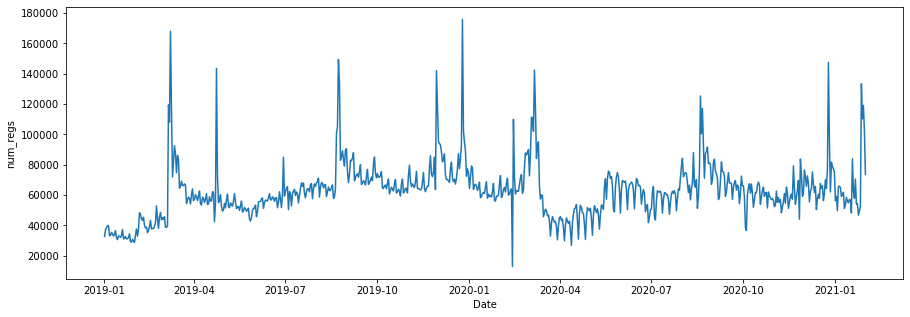

In [20]:
# Plot registrations data with and without outliers
plt.figure(figsize=(15, 5))
sns.lineplot(data=modelling_dataset, x='Date', y='num_regs');

Now lets take a look at correlation matrix for chosen variables

In [21]:
modelling_dataset['Week'] = modelling_dataset['Date'].apply(lambda x: x.week)
modelling_dataset['Year'] = modelling_dataset['Date'].apply(lambda x: x.year)

In [23]:
smart_data = pd.read_excel('SMART Data 2.24.xlsx')

In [24]:
smart_data.head()

,Year,Semi-Year,Week,Month,Quarter,Account,Carrier,Vendor,Market Name,Payment,PHABLET,ModelCD,Program,Device,DeviceSub,OS,Memory,SellOut,WSP,EP,FRP,Revenue(WSP),Revenue(EP),Revenue(FRP),Price Band(WSP),Price Band(FRP) $100,Price Band(FRP),PRICE TIER(FRP),Generation,Family,Connectivity,Confidential
0,2019,2019 2H,202001,201912,2019Q4,T-Mobile,T-MOBILE,Apple,iPhone 11 Pro Max(256GB),POSTPAID,Phablet,IPHONE 11 PRO MAX/M256,iPhone 11 Pro Max,Phone,SMART,Apple,256GB,325,0.00,0.00,1249.99,0.00,0.00,406246.75,~ $99.94,$1199.95 ~ $1299.94,+$1199.95 ~,Hyper Premium,N,iPhone 11,4G,NaN
1,2019,2019 2H,202001,201912,2019Q4,AT&T,AT&T,Apple,iPhone 11 Pro Max(512GB),POSTPAID,Phablet,IPHONE 11 PRO MAX/M512,iPhone 11 Pro Max,Phone,SMART,Apple,512GB,806,0.00,0.00,1449.99,0.00,0.00,1168691.94,~ $99.94,$1399.95 ~ $1499.94,+$1199.95 ~,Hyper Premium,N,iPhone 11,4G,NaN
2,2019,2019 2H,202001,201912,2019Q4,AT&T,AT&T,Samsung,Galaxy-A10e,POSTPAID,Non-Phablet,A102/M32,Galaxy A10e,Phone,SMART,Android,32GB,2657,145.34,145.34,209.99,386168.38,386168.38,557943.43,$99.95 ~ $299.94,$199.95 ~ $299.94,$99.95 ~ $299.94,Entry,NaN,A & J Series,4G,NaN
3,2019,2019 2H,202001,201912,2019Q4,AT&T,AT&T,Samsung,Galaxy-J2-Core,POSTPAID,Non-Phablet,J260/M16,Galaxy J2 Core,Phone,SMART,Android,16GB,3267,125.37,125.37,99.99,409583.79,409583.79,326667.33,$99.95 ~ $299.94,$99.95 ~ $199.94,$99.95 ~ $299.94,Entry,NaN,A & J Series,4G,NaN
4,2019,2019 2H,202001,201912,2019Q4,AT&T,Apple Store (AT&T),Apple,IPHONE 6S - 32GB,PREPAID,Non-Phablet,IPHONE 6S - 32GB,iphone 6S,Phone,SMART,Apple,32GB,290,0.00,0.00,149.00,0.00,0.00,43210.00,~ $99.94,$99.95 ~ $199.94,$99.95 ~ $299.94,Entry,N-4,iPhone 6S,4G,NaN


In [25]:
smart_data = pd.read_excel('SMART Data 2.24.xlsx')
smart_data_temp = smart_data[['Week', 'Vendor', 'SellOut', 'FRP']]

smart_data_sellout = pd.pivot_table(smart_data_temp, values='SellOut', index='Week', columns='Vendor', aggfunc=np.sum).reset_index().fillna(0)
vendors_names = list(smart_data_sellout.drop(columns = ['Week']).columns)
smart_data_sellout['Grand Total'] = smart_data_sellout[vendors_names].sum(axis = 1)

for vend in vendors_names:
    if vend != 'Samsung':
        smart_data_sellout[vend] = smart_data_sellout[vend]/(smart_data_sellout['Grand Total'] - smart_data_sellout['Samsung'])
        
smart_data_frp = pd.pivot_table(smart_data_temp, values='FRP', index='Week', columns='Vendor', aggfunc=np.mean).reset_index().fillna(0)

for vend in vendors_names:
    if vend != 'Samsung':
        smart_data_frp[vend] = smart_data_frp[vend]*smart_data_sellout[vend]
        
vendors_names_ex = [x for x in vendors_names if x != 'Samsung']

rsp_table = pd.DataFrame()
rsp_table['Week'] = smart_data_frp['Week']
rsp_table['Non-samsung'] = smart_data_frp[vendors_names_ex].sum(axis = 1)
rsp_table['Samsung'] = smart_data_frp['Samsung']
rsp_table['Samsung_Relative_Price'] = rsp_table['Samsung'] / rsp_table['Non-samsung']

In [26]:
rsp_table['Year'] = rsp_table['Week'].apply(lambda x: int(x / 100))
rsp_table['Week'] = rsp_table['Week'].apply(lambda x: int(x % 100))

In [27]:
rsp_table = rsp_table.drop(columns = ['Non-samsung', 'Samsung'])

In [28]:
modelling_dataset = pd.merge(modelling_dataset, rsp_table, on = ['Year', 'Week'], how = 'left')

<AxesSubplot:>

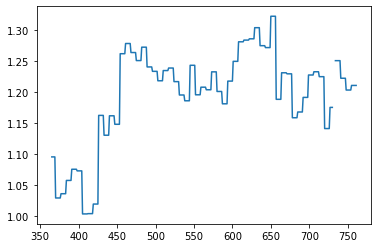

In [29]:
modelling_dataset['Samsung_Relative_Price'].plot()

In [31]:
last_dataset = pd.read_excel('modelling_dataset_ver_18_2020_10_14_12_00_00.xlsx')

last_dataset['Year'] = last_dataset['Date'].apply(lambda x: x.year)
last_dataset['Week'] = last_dataset['Date'].apply(lambda x: x.week)

last_dataset = last_dataset[['Week', 'Year', 'Samsung_Relative_Price']].copy()

In [32]:
modelling_dataset

,Date,num_regs,Audio_Clicks_cold,Audio_cost_cold,Audio_Clicks_hot,Audio_cost_hot,Audio_Clicks_warm,Audio_cost_warm,YouTube_DD_Clicks_cold,YouTube_DD_cost_cold,YouTube_DD_Clicks_hot,YouTube_DD_cost_hot,YouTube_DD_Clicks_warm,YouTube_DD_cost_warm,YouTube_OLV_Impressions_cold,YouTube_OLV_cost_cold,YouTube_OLV_Impressions_hot,YouTube_OLV_cost_hot,YouTube_OLV_Impressions_warm,YouTube_OLV_cost_warm,OTT_Impressions_cold,OTT_cost_cold,OTT_Impressions_hot,OTT_cost_hot,OTT_Impressions_warm,OTT_cost_warm,PDM_Impressions_cold,PDM_cost_cold,PDM_Impressions_hot,PDM_cost_hot,PDM_Impressions_warm,PDM_cost_warm,POLV_Clicks_cold,POLV_cost_cold,POLV_Clicks_hot,POLV_cost_hot,POLV_Clicks_warm,POLV_cost_warm,OOH_Impressions_cold,OOH_cost_cold,OOH_Impressions_hot,OOH_cost_hot,OOH_Impressions_warm,OOH_cost_warm,Partnership_Impressions_cold,Partnership_cost_cold,Partnership_Impressions_hot,Partnership_cost_hot,Partnership_Impressions_warm,Partnership_cost_warm,Primary_Search_Impressions_hot,Primary_Search_cost_hot,Secondary_Search_Impressions_hot,Secondary_Search_cost_hot,Facebook_Impressions_cold,Facebook_cost_cold,Facebook_Impressions_hot,Facebook_cost_hot,Facebook_Impressions_warm,Facebook_cost_warm,Social_Impressions_cold,Social_cost_cold,Social_Impressions_warm,Social_cost_warm,Social_Impressions_hot,Social_cost_hot,DD_Impressions_cold,DD_cost_cold,DD_Impressions_hot,DD_cost_hot,DD_Impressions_warm,DD_cost_warm,OLV_Clicks_cold,OLV_cost_cold,OLV_Clicks_hot,OLV_cost_hot,OLV_Clicks_warm,OLV_cost_warm,NASDAQ_Opens,CPI,Consumer_Sentiment_Index,Unemployed,Week,Year,Samsung_Relative_Price
0,2019-01-01,32632,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000,0.0,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.0,0.0,0.0,0.0,0,0.00,0.0,0.000000,0.0,0.0,1649302.0,21717.02,0.0,0.0,0.0,0.000000,0.0,0.000000,799458.0,4544.00,437575.0,6523.000000,0.0,0.0,0.0,0.000000,16233.0,207099.000000,0.0,0.000,0.0,0.000,6635.277,252.550,91.2,6516,1,2019,NaN
1,2019-01-02,36972,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000,0.0,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.0,0.0,0.0,0.0,0,0.00,1825344.0,20489.109846,0.0,0.0,1959462.0,21013.03,0.0,0.0,0.0,0.000000,0.0,0.000000,6399838.0,30652.28,623641.0,9303.000000,0.0,0.0,0.0,0.000000,14675.0,155578.000000,0.0,0.000,0.0,0.000,6665.938,252.550,91.2,6516,1,2019,NaN
2,2019-01-03,38625,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000,0.0,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,18105.0,483.855,0.0,0.0,0.0,0.0,0,0.00,3533850.0,41329.690518,0.0,0.0,2383070.0,29211.74,0.0,0.0,0.0,0.000000,0.0,0.000000,7207906.0,34739.22,600136.0,8953.000000,0.0,0.0,0.0,0.000000,9801.0,165150.000000,0.0,0.000,0.0,0.000,6463.504,252.550,91.2,6516,1,2019,NaN
3,2019-01-04,39416,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000,0.0,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,92993.0,2564.520,0.0,0.0,0.0,0.0,0,0.00,5936346.0,52231.073414,0.0,0.0,1543668.0,21811.01,0.0,0.0,0.0,0.000000,0.0,0.000000,7178797.0,34657.95,557563.0,8312.000000,0.0,0.0,0.0,0.000000,9865.0,117164.000000,0.0,0.000,0.0,0.000,6738.855,252.550,91.2,6516,1,2019,NaN
4,2019-01-05,39936,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000,0.0,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,44214.0,1250.750,0.0,0.0,0.0,0.0,0,0.00,6088706.0,38012.600354,0.0,0.0,2902881.0,34313.94,0.0,0.0,0.0,0.000000,0.0,0.000000,7156426.0,34980.73,683271.0,17708.000000,0.0,0.0,0.0,0.000000,9100.0,89207.000000,0.0,0.000,0.0,0.000,6738.855,252.550,91.2,6516,1,2019,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,.

In [33]:
modelling_dataset = pd.merge(modelling_dataset, last_dataset, on = ['Year', 'Week'], how = 'left').reset_index(drop = True)

In [34]:
modelling_dataset['Samsung_Relative_Price'] = modelling_dataset.apply(lambda x: x['Samsung_Relative_Price_y'] if x['Date'] < datetime.datetime(2020,1,1) else x['Samsung_Relative_Price_x'], axis = 1)

In [35]:
modelling_dataset

,Date,num_regs,Audio_Clicks_cold,Audio_cost_cold,Audio_Clicks_hot,Audio_cost_hot,Audio_Clicks_warm,Audio_cost_warm,YouTube_DD_Clicks_cold,YouTube_DD_cost_cold,YouTube_DD_Clicks_hot,YouTube_DD_cost_hot,YouTube_DD_Clicks_warm,YouTube_DD_cost_warm,YouTube_OLV_Impressions_cold,YouTube_OLV_cost_cold,YouTube_OLV_Impressions_hot,YouTube_OLV_cost_hot,YouTube_OLV_Impressions_warm,YouTube_OLV_cost_warm,OTT_Impressions_cold,OTT_cost_cold,OTT_Impressions_hot,OTT_cost_hot,OTT_Impressions_warm,OTT_cost_warm,PDM_Impressions_cold,PDM_cost_cold,PDM_Impressions_hot,PDM_cost_hot,PDM_Impressions_warm,PDM_cost_warm,POLV_Clicks_cold,POLV_cost_cold,POLV_Clicks_hot,POLV_cost_hot,POLV_Clicks_warm,POLV_cost_warm,OOH_Impressions_cold,OOH_cost_cold,OOH_Impressions_hot,OOH_cost_hot,OOH_Impressions_warm,OOH_cost_warm,Partnership_Impressions_cold,Partnership_cost_cold,Partnership_Impressions_hot,Partnership_cost_hot,Partnership_Impressions_warm,Partnership_cost_warm,Primary_Search_Impressions_hot,Primary_Search_cost_hot,Secondary_Search_Impressions_hot,Secondary_Search_cost_hot,Facebook_Impressions_cold,Facebook_cost_cold,Facebook_Impressions_hot,Facebook_cost_hot,Facebook_Impressions_warm,Facebook_cost_warm,Social_Impressions_cold,Social_cost_cold,Social_Impressions_warm,Social_cost_warm,Social_Impressions_hot,Social_cost_hot,DD_Impressions_cold,DD_cost_cold,DD_Impressions_hot,DD_cost_hot,DD_Impressions_warm,DD_cost_warm,OLV_Clicks_cold,OLV_cost_cold,OLV_Clicks_hot,OLV_cost_hot,OLV_Clicks_warm,OLV_cost_warm,NASDAQ_Opens,CPI,Consumer_Sentiment_Index,Unemployed,Week,Year,Samsung_Relative_Price_x,Samsung_Relative_Price_y,Samsung_Relative_Price
0,2019-01-01,32632,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000,0.0,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.00,0.0,0.000,0.0,0.0,1649302.0,21717.02,0.0,0.0,0.0,0.000000,0.0,0.000000,799458.0,4544.00,437575.0,6523.000000,0.0,0.0,0.0,0.000000,16233.0,207099.000000,0.0,0.000,0.0,0.000,6635.277,252.550,91.2,6516,1,2019,NaN,0.986248,0.986248
1,2019-01-01,32632,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000,0.0,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.00,0.0,0.000,0.0,0.0,1649302.0,21717.02,0.0,0.0,0.0,0.000000,0.0,0.000000,799458.0,4544.00,437575.0,6523.000000,0.0,0.0,0.0,0.000000,16233.0,207099.000000,0.0,0.000,0.0,0.000,6635.277,252.550,91.2,6516,1,2019,NaN,0.986248,0.986248
2,2019-01-01,32632,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000,0.0,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.00,0.0,0.000,0.0,0.0,1649302.0,21717.02,0.0,0.0,0.0,0.000000,0.0,0.000000,799458.0,4544.00,437575.0,6523.000000,0.0,0.0,0.0,0.000000,16233.0,207099.000000,0.0,0.000,0.0,0.000,6635.277,252.550,91.2,6516,1,2019,NaN,0.986248,0.986248
3,2019-01-01,32632,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000,0.0,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.00,0.0,0.000,0.0,0.0,1649302.0,21717.02,0.0,0.0,0.0,0.000000,0.0,0.000000,799458.0,4544.00,437575.0,6523.000000,0.0,0.0,0.0,0.000000,16233.0,207099.000000,0.0,0.000,0.0,0.000,6635.277,252.550,91.2,6516,1,2019,NaN,0.986248,0.986248
4,2019-01-01,32632,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000,0.0,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.00,0.0,0.000,0.0,0.0,1649302.0,21717.02,0.0,0.0,0.0,0.000000,0.0,0.000000,799458.0,4544.00,437575.0,6523.000000,0.0,0.0,0.0,0.000000,16233.0,207099.000000,0.0,0.000,0.0,0.000,6635.277,252.550,91.2,6516,1,2019,NaN,0.986248,0.986248
...,...,...

In [36]:
# Drop columns that we wont need for analysis
# modelling_dataset.drop(columns=['Consumer_Sentiment_Index', 'CPI',
#                                 'Month', 'Year'], inplace=True)
modelling_dataset.drop(columns=['Week', 'Year','Samsung_Relative_Price_x', 'Samsung_Relative_Price_y'], inplace=True)

In [37]:
modelling_dataset

,Date,num_regs,Audio_Clicks_cold,Audio_cost_cold,Audio_Clicks_hot,Audio_cost_hot,Audio_Clicks_warm,Audio_cost_warm,YouTube_DD_Clicks_cold,YouTube_DD_cost_cold,YouTube_DD_Clicks_hot,YouTube_DD_cost_hot,YouTube_DD_Clicks_warm,YouTube_DD_cost_warm,YouTube_OLV_Impressions_cold,YouTube_OLV_cost_cold,YouTube_OLV_Impressions_hot,YouTube_OLV_cost_hot,YouTube_OLV_Impressions_warm,YouTube_OLV_cost_warm,OTT_Impressions_cold,OTT_cost_cold,OTT_Impressions_hot,OTT_cost_hot,OTT_Impressions_warm,OTT_cost_warm,PDM_Impressions_cold,PDM_cost_cold,PDM_Impressions_hot,PDM_cost_hot,PDM_Impressions_warm,PDM_cost_warm,POLV_Clicks_cold,POLV_cost_cold,POLV_Clicks_hot,POLV_cost_hot,POLV_Clicks_warm,POLV_cost_warm,OOH_Impressions_cold,OOH_cost_cold,OOH_Impressions_hot,OOH_cost_hot,OOH_Impressions_warm,OOH_cost_warm,Partnership_Impressions_cold,Partnership_cost_cold,Partnership_Impressions_hot,Partnership_cost_hot,Partnership_Impressions_warm,Partnership_cost_warm,Primary_Search_Impressions_hot,Primary_Search_cost_hot,Secondary_Search_Impressions_hot,Secondary_Search_cost_hot,Facebook_Impressions_cold,Facebook_cost_cold,Facebook_Impressions_hot,Facebook_cost_hot,Facebook_Impressions_warm,Facebook_cost_warm,Social_Impressions_cold,Social_cost_cold,Social_Impressions_warm,Social_cost_warm,Social_Impressions_hot,Social_cost_hot,DD_Impressions_cold,DD_cost_cold,DD_Impressions_hot,DD_cost_hot,DD_Impressions_warm,DD_cost_warm,OLV_Clicks_cold,OLV_cost_cold,OLV_Clicks_hot,OLV_cost_hot,OLV_Clicks_warm,OLV_cost_warm,NASDAQ_Opens,CPI,Consumer_Sentiment_Index,Unemployed,Samsung_Relative_Price
0,2019-01-01,32632,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000,0.0,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.00,0.0,0.000,0.0,0.0,1649302.0,21717.02,0.0,0.0,0.0,0.000000,0.0,0.000000,799458.0,4544.00,437575.0,6523.000000,0.0,0.0,0.0,0.000000,16233.0,207099.000000,0.0,0.000,0.0,0.000,6635.277,252.550,91.2,6516,0.986248
1,2019-01-01,32632,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000,0.0,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.00,0.0,0.000,0.0,0.0,1649302.0,21717.02,0.0,0.0,0.0,0.000000,0.0,0.000000,799458.0,4544.00,437575.0,6523.000000,0.0,0.0,0.0,0.000000,16233.0,207099.000000,0.0,0.000,0.0,0.000,6635.277,252.550,91.2,6516,0.986248
2,2019-01-01,32632,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000,0.0,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.00,0.0,0.000,0.0,0.0,1649302.0,21717.02,0.0,0.0,0.0,0.000000,0.0,0.000000,799458.0,4544.00,437575.0,6523.000000,0.0,0.0,0.0,0.000000,16233.0,207099.000000,0.0,0.000,0.0,0.000,6635.277,252.550,91.2,6516,0.986248
3,2019-01-01,32632,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000,0.0,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.00,0.0,0.000,0.0,0.0,1649302.0,21717.02,0.0,0.0,0.0,0.000000,0.0,0.000000,799458.0,4544.00,437575.0,6523.000000,0.0,0.0,0.0,0.000000,16233.0,207099.000000,0.0,0.000,0.0,0.000,6635.277,252.550,91.2,6516,0.986248
4,2019-01-01,32632,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000,0.0,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.00,0.0,0.000,0.0,0.0,1649302.0,21717.02,0.0,0.0,0.0,0.000000,0.0,0.000000,799458.0,4544.00,437575.0,6523.000000,0.0,0.0,0.0,0.000000,16233.0,207099.000000,0.0,0.000,0.0,0.000,6635.277,252.550,91.2,6516,0.986248
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...

In [38]:
first_date_new = modelling_dataset['Date'][0]

In [39]:
last_dataset = pd.read_excel('modelling_dataset_ver_18_2020_10_14_12_00_00.xlsx').drop(columns = ['Unnamed: 0'])
srp_dict = last_dataset[['Date','Samsung_Relative_Price']].groupby('Date').sum().to_dict()['Samsung_Relative_Price']

In [40]:
modelling_dataset['Samsung_Relative_Price'] = modelling_dataset.apply(lambda x: srp_dict[x['Date']] if x['Date'] < first_date_new else x['Samsung_Relative_Price'], axis=1)

In [41]:
modelling_dataset

,Date,num_regs,Audio_Clicks_cold,Audio_cost_cold,Audio_Clicks_hot,Audio_cost_hot,Audio_Clicks_warm,Audio_cost_warm,YouTube_DD_Clicks_cold,YouTube_DD_cost_cold,YouTube_DD_Clicks_hot,YouTube_DD_cost_hot,YouTube_DD_Clicks_warm,YouTube_DD_cost_warm,YouTube_OLV_Impressions_cold,YouTube_OLV_cost_cold,YouTube_OLV_Impressions_hot,YouTube_OLV_cost_hot,YouTube_OLV_Impressions_warm,YouTube_OLV_cost_warm,OTT_Impressions_cold,OTT_cost_cold,OTT_Impressions_hot,OTT_cost_hot,OTT_Impressions_warm,OTT_cost_warm,PDM_Impressions_cold,PDM_cost_cold,PDM_Impressions_hot,PDM_cost_hot,PDM_Impressions_warm,PDM_cost_warm,POLV_Clicks_cold,POLV_cost_cold,POLV_Clicks_hot,POLV_cost_hot,POLV_Clicks_warm,POLV_cost_warm,OOH_Impressions_cold,OOH_cost_cold,OOH_Impressions_hot,OOH_cost_hot,OOH_Impressions_warm,OOH_cost_warm,Partnership_Impressions_cold,Partnership_cost_cold,Partnership_Impressions_hot,Partnership_cost_hot,Partnership_Impressions_warm,Partnership_cost_warm,Primary_Search_Impressions_hot,Primary_Search_cost_hot,Secondary_Search_Impressions_hot,Secondary_Search_cost_hot,Facebook_Impressions_cold,Facebook_cost_cold,Facebook_Impressions_hot,Facebook_cost_hot,Facebook_Impressions_warm,Facebook_cost_warm,Social_Impressions_cold,Social_cost_cold,Social_Impressions_warm,Social_cost_warm,Social_Impressions_hot,Social_cost_hot,DD_Impressions_cold,DD_cost_cold,DD_Impressions_hot,DD_cost_hot,DD_Impressions_warm,DD_cost_warm,OLV_Clicks_cold,OLV_cost_cold,OLV_Clicks_hot,OLV_cost_hot,OLV_Clicks_warm,OLV_cost_warm,NASDAQ_Opens,CPI,Consumer_Sentiment_Index,Unemployed,Samsung_Relative_Price
0,2019-01-01,32632,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000,0.0,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.00,0.0,0.000,0.0,0.0,1649302.0,21717.02,0.0,0.0,0.0,0.000000,0.0,0.000000,799458.0,4544.00,437575.0,6523.000000,0.0,0.0,0.0,0.000000,16233.0,207099.000000,0.0,0.000,0.0,0.000,6635.277,252.550,91.2,6516,0.986248
1,2019-01-01,32632,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000,0.0,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.00,0.0,0.000,0.0,0.0,1649302.0,21717.02,0.0,0.0,0.0,0.000000,0.0,0.000000,799458.0,4544.00,437575.0,6523.000000,0.0,0.0,0.0,0.000000,16233.0,207099.000000,0.0,0.000,0.0,0.000,6635.277,252.550,91.2,6516,0.986248
2,2019-01-01,32632,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000,0.0,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.00,0.0,0.000,0.0,0.0,1649302.0,21717.02,0.0,0.0,0.0,0.000000,0.0,0.000000,799458.0,4544.00,437575.0,6523.000000,0.0,0.0,0.0,0.000000,16233.0,207099.000000,0.0,0.000,0.0,0.000,6635.277,252.550,91.2,6516,0.986248
3,2019-01-01,32632,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000,0.0,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.00,0.0,0.000,0.0,0.0,1649302.0,21717.02,0.0,0.0,0.0,0.000000,0.0,0.000000,799458.0,4544.00,437575.0,6523.000000,0.0,0.0,0.0,0.000000,16233.0,207099.000000,0.0,0.000,0.0,0.000,6635.277,252.550,91.2,6516,0.986248
4,2019-01-01,32632,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000,0.0,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.00,0.0,0.000,0.0,0.0,1649302.0,21717.02,0.0,0.0,0.0,0.000000,0.0,0.000000,799458.0,4544.00,437575.0,6523.000000,0.0,0.0,0.0,0.000000,16233.0,207099.000000,0.0,0.000,0.0,0.000,6635.277,252.550,91.2,6516,0.986248
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...

In [42]:
modelling_dataset.to_excel('dataset_2021_v3.xlsx')

In [43]:
modelling_dataset['NASDAQ_Opens'] = modelling_dataset['NASDAQ_Opens'].apply(lambda x: x if type(x) == float else np.nan)
modelling_dataset['NASDAQ_Opens'].fillna(method = 'ffill').values

array([ 6635.277,  6635.277,  6635.277, ..., 13070.69 , 13070.69 ,
       13070.69 ])

In [44]:
smart_data = pd.read_excel('SMART Data 2.24.xlsx')
smart_data_temp = smart_data[['Week', 'Vendor', 'SellOut', 'FRP']]

smart_data_sellout = pd.pivot_table(smart_data_temp, values='SellOut', index='Week', columns='Vendor', aggfunc=np.sum).reset_index().fillna(0)
vendors_names = list(smart_data_sellout.drop(columns = ['Week']).columns)
smart_data_sellout['Grand Total'] = smart_data_sellout[vendors_names].sum(axis = 1)

for vend in vendors_names:
    if vend != 'Samsung':
        smart_data_sellout[vend] = smart_data_sellout[vend]/(smart_data_sellout['Grand Total'] - smart_data_sellout['Samsung'])
        
smart_data_frp = pd.pivot_table(smart_data_temp, values='FRP', index='Week', columns='Vendor', aggfunc=np.mean).reset_index().fillna(0)

for vend in vendors_names:
    if vend != 'Samsung':
        smart_data_frp[vend] = smart_data_frp[vend]*smart_data_sellout[vend]
        
vendors_names_ex = [x for x in vendors_names if x != 'Samsung']

rsp_table = pd.DataFrame()
rsp_table['Week'] = smart_data_frp['Week']
rsp_table['Non-samsung'] = smart_data_frp[vendors_names_ex].sum(axis = 1)
rsp_table['Samsung'] = smart_data_frp['Samsung']
rsp_table['Samsung_Relative_Price'] = rsp_table['Samsung'] / rsp_table['Non-samsung']

#### Export modelling dataset

In [45]:
tag = 'ver_3_' + str(datetime.datetime.now().strftime('%Y'+'_'+'%m'+'_'+'%d'+'_'+'%H'+'_'+'%M'+'_'+'%S'))
modelling_dataset.to_csv('../data/model_inputs/modelling_dataset_' + tag + '.csv', sep=';', index=False)
modelling_dataset.to_excel('../data/model_inputs/modelling_dataset_' + tag + '.xlsx', index=False)

FileNotFoundError: [Errno 2] No such file or directory: '../data/model_inputs/modelling_dataset_ver_3_2022_04_02_21_50_58.csv'